# Competition baseline

## 数据处理

In [3]:
import numpy as np
import pandas as pd

In [4]:
import os
# 读取路径下所有文件
for dirname, _, filenames in os.walk('../quick_baseline/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../quick_baseline/first_baseline.ipynb
../quick_baseline/sample_submission.csv
../quick_baseline/test_data.csv
../quick_baseline/train_data.csv


In [1]:
# import packages
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
import multiprocessing

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold, ShuffleSplit, StratifiedKFold
from sklearn.metrics import roc_auc_score, log_loss

In [5]:
train_df = pd.read_csv('../quick_baseline/train_data.csv')
test_df = pd.read_csv('../quick_baseline/test_data.csv')

In [6]:
# change type
train_df['label'] = train_df['label'].astype('int32')

In [7]:
# 合并训练集测试集，方便编码等处理
df = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)

In [8]:
df.head(5) # first 5 lines

,label,user_id,item_id,item_fea1,user_fea1,user_fea2,user_fea3,user_fea4,lng,lat,user_fea5,ts,user_fea6,user_fea7,user_fea8,user_fea9,user_tag,ID
0,0.0,WgwGia5U3IS4BXkm,WORhuXJqpf4brDGS,2,KmsYcoDyQi7zprXT,yrLNj2BzDhEQTws5,3Xvgq4YJCV2DHb0o,wLQbAfi9agGtNj8M,108.664005,22.244352,W8b1IqPHxX9aGQYF,1573193245778,0.0,10.0,28.0,0.0,"['1', '2', '3', '4', '5', '6', '7', '8', '9', ...",0
1,0.0,WgwGia5U3IS4BXkm,WORhuXJqpf4brDGS,2,KmsYcoDyQi7zprXT,yrLNj2BzDhEQTws5,3Xvgq4YJCV2DHb0o,wLQbAfi9agGtNj8M,108.664005,22.244352,W8b1IqPHxX9aGQYF,1573193245778,0.0,10.0,28.0,0.0,"['62', '63', '64', '65', '3', '66', '8', '9', ...",1
2,0.0,WgwGia5U3IS4BXkm,zJnsmI6OET3jSUuB,0,KmsYcoDyQi7zprXT,yrLNj2BzDhEQTws5,OoFYqTPyxKfASCwR,wLQbAfi9agGtNj8M,108.665033,22.246721,W8b1IqPHxX9aGQYF,1573300837960,0.0,10.0,28.0,0.0,"['1', '2', '3', '4', '5', '6', '7', '8', '9', ...",2
3,0.0,WgwGia5U3IS4BXkm,zJnsmI6OET3jSUuB,0,KmsYcoDyQi7zprXT,yrLNj2BzDhEQTws5,OoFYqTPyxKfASCwR,wLQbAfi9agGtNj8M,108.665033,22.246721,W8b1IqPHxX9aGQYF,1573300837960,0.0,10.0,28.0,0.0,"['62', '63', '64', '65', '3', '66', '8', '9', ...",3
4,0.0,WgwGia5U3IS4BXkm,zJnsmI6OET3jSUuB,0,KmsYcoDyQi7zprXT,yrLNj2BzDhEQTws5,OoFYqTPyxKfASCwR,wLQbAfi9agGtNj8M,108.665033,22.246721,W8b1IqPHxX9aGQYF,1573311745524,0.0,10.0,28.0,0.0,"['1', '2', '3', '4', '5', '6', '7', '8', '9', ...",4


In [9]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5811458 entries, 0 to 5811457
Data columns (total 18 columns):
 #   Column     Dtype  
---  ------     -----  
 0   label      float64
 1   user_id    object 
 2   item_id    object 
 3   item_fea1  int64  
 4   user_fea1  object 
 5   user_fea2  object 
 6   user_fea3  object 
 7   user_fea4  object 
 8   lng        float64
 9   lat        float64
 10  user_fea5  object 
 11  ts         int64  
 12  user_fea6  float64
 13  user_fea7  float64
 14  user_fea8  float64
 15  user_fea9  float64
 16  user_tag   object 
 17  ID         int64  
dtypes: float64(7), int64(3), object(8)
memory usage: 798.1+ MB


In [10]:
num_cols  =  [f'user_fea{i}' for i in range(6,9)] 
cate_cols = ['user_id','item_id']+ [f'user_fea{i}' for i in range(1,6)] + ['item_fea1']+['user_fea9']
num_cols, cate_cols

(['user_fea6', 'user_fea7', 'user_fea8'],
 ['user_id',
  'item_id',
  'user_fea1',
  'user_fea2',
  'user_fea3',
  'user_fea4',
  'user_fea5',
  'item_fea1',
  'user_fea9'])

In [11]:
num_cols, cate_cols

(['user_fea6', 'user_fea7', 'user_fea8'],
 ['user_id',
  'item_id',
  'user_fea1',
  'user_fea2',
  'user_fea3',
  'user_fea4',
  'user_fea5',
  'item_fea1',
  'user_fea9'])

C:\Users\Administrator\AppData\Local\Temp\ipykernel_17452\2269448524.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])
c:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN 

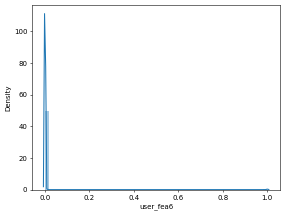

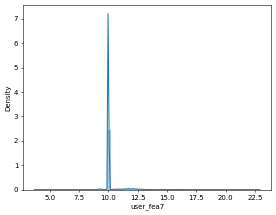

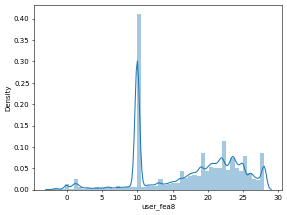

In [12]:
# 连续特征
for col in num_cols:
    plt.figure(dpi=50)
    sns.distplot(df[col])

In [13]:
# 原生数据编码
for col in num_cols:
    df[col] = df[col].fillna(0)
    # min-max
    # df[col] = (df[col] - df[col].mean()) / (df[col].max() - df[col].min())
    
    # z-score
    df[col] = (df[col] - df[col].mean()) / df[col].std()

In [14]:
train_df['label'].groupby(train_df['label']).value_counts()

label  label
0      0        2915522
1      1         614730
Name: count, dtype: int64

In [15]:
# sklearn 数据编码
# scaler = StandardScaler()
# scaler = MinMaxScaler()
# df[num_cols] = scaler.fit_transform(df[num_cols])

# train_df[num_cols] = scaler.fit(train_df[num_cols])

# train_df[num_cols] = scaler.transform(train_df[num_cols])
# test_df[num_cols] = scaler.transform(test_df[num_cols])

In [16]:
# 离散特征
# for col in ['user_fea1', 'user_fea2', 'user_fea3', 'user_fea4', 'user_fea5', 'item_fea1', 'user_fea9']:
#     plt.figure(dpi=150)
#     sns.countplot(df[col])

c:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='label', ylabel='Count'>

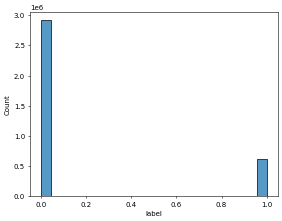

In [17]:
plt.figure(dpi=50)
sns.histplot(train_df['label'])

In [18]:
# 原生离散特征编码
# 操作df一列：
# 1.map方法：输入一个dict(k:v对)
# 2.apply方法：输入一个func,这个func的输入是该列特征的一个值，返回结果是修改后的值
for col in cate_cols:
    df[col] = df[col].fillna('-1')
    map_dict = dict(zip(df[col].unique(), range(df[col].nunique())))

    df[col] = df[col].map(map_dict)
    df[f'{col}_count'] = df[col].map(df[col].value_counts())

In [19]:
# 需要维护一个map_dict来定义映射的方法
map_dict = dict(zip(train_df['user_fea1'].unique(), range(train_df['user_fea1'].nunique())))

In [20]:
def func1(x):
    return '666_' + x

In [21]:
train_df['user_fea1'].apply(func1)

0          666_KmsYcoDyQi7zprXT
1          666_KmsYcoDyQi7zprXT
2          666_KmsYcoDyQi7zprXT
3          666_KmsYcoDyQi7zprXT
4          666_KmsYcoDyQi7zprXT
                   ...         
3530247    666_J2lywfeYA6Cov3mu
3530248    666_J2lywfeYA6Cov3mu
3530249    666_J2lywfeYA6Cov3mu
3530250    666_J2lywfeYA6Cov3mu
3530251    666_J2lywfeYA6Cov3mu
Name: user_fea1, Length: 3530252, dtype: object

In [22]:
# sklearn 离散特征编码
for col in cate_cols:
    scale = LabelEncoder()
    scale.fit(df[col])
    df[col] = scale.transform(df[col])

In [23]:
# 分割数据
train_df = df[df['label'].notna()].reset_index(drop=True)
test_df = df[df['label'].isna()].reset_index(drop=True)
train_df.shape, test_df.shape

((3530252, 27), (2281206, 27))

In [24]:
# 删除不需要的特征
drop_feature = ['ID','label','lng','lat','ts','user_tag']
feature = [x for x in train_df.columns if x not in drop_feature]
print(len(feature), feature)

21 ['user_id', 'item_id', 'item_fea1', 'user_fea1', 'user_fea2', 'user_fea3', 'user_fea4', 'user_fea5', 'user_fea6', 'user_fea7', 'user_fea8', 'user_fea9', 'user_id_count', 'item_id_count', 'user_fea1_count', 'user_fea2_count', 'user_fea3_count', 'user_fea4_count', 'user_fea5_count', 'item_fea1_count', 'user_fea9_count']


## 模型调用

In [25]:
### sklearn一般的范式
'''
# 实例化模型
model = XXX(**params)

# 拟合模型
model.fit(X_train, y_train)

# 模型预测 类别
model.predict(X_test)

# 输出概率(分类任务)
model.predict_proba(X_test)

# 获得这个模型的参数
model.get_params()
'''

'\n# 实例化模型\nmodel = XXX(**params)\n\n# 拟合模型\nmodel.fit(X_train, y_train)\n\n# 模型预测 类别\nmodel.predict(X_test)\n\n# 输出概率(分类任务)\nmodel.predict_proba(X_test)\n\n# 获得这个模型的参数\nmodel.get_params()\n'

In [26]:
# split data
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(train_df[feature], train_df['label'], random_state=666)

In [27]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((2647689, 21), (882563, 21), (2647689,), (882563,))

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

In [29]:
model = AdaBoostClassifier()
model.fit(X_train, Y_train)

AdaBoostClassifier()

In [30]:
y_test_pre = model.predict_proba(X_test)[:, 1]
print(f'{str(model)} AUC: {roc_auc_score(Y_test, y_test_pre)}')
print(f'{str(model)} LogLoss: {log_loss(Y_test, y_test_pre)}')

AdaBoostClassifier() AUC: 0.8026027777302978
AdaBoostClassifier() LogLoss: 0.6741827729451837


In [31]:
# 测试集预测
y_pre = model.predict_proba(test_df[feature])[:, 1]

In [32]:
# 提交格式
sklearn_sub_df = pd.DataFrame()
sklearn_sub_df['ID'] = test_df['ID']
sklearn_sub_df['label'] = y_pre
sklearn_sub_df.to_csv('../quick_baseline/sklearn_baseline.csv',index=False)

## 模型验证

In [33]:
# 交叉验证参数
params = {"num_leaves": 63, #结果对最终效果影响较大，越大值越好，太大会出现过拟合
          "objective": 'binary', #定义的目标函数
          "max_depth": 8,
          "learning_rate": 0.1,
          "min_sum_hessian_in_leaf": 6,
          "boosting": "gbdt",
          "feature_fraction": 1,  #提取的特征比率
          "bagging_freq": 1,
          "bagging_fraction": 1,
          "bagging_seed": 11,
        #   "lambda_l1": 0.1,             #l1正则
        #   "lambda_l2": 0.001,     #l2正则
          "verbosity": -1,
          "nthread": multiprocessing.cpu_count(),                #线程数量，-1表示全部线程，线程越多，运行的速度越快
          "metric": {'binary_logloss', 'auc'},  ##评价函数选择
          "random_state": 2077, #随机数种子，可以防止每次运行的结果不一致
        #   "device": 'gpu' ##如果安装的事gpu版本的lightgbm,可以加快运算
          }

n_fold = 5
oof_pre =  np.zeros(len(train_df))
y_pre = np.zeros(len(test_df))

kf = KFold(n_splits=n_fold)
callbacks = [
    lgb.early_stopping(50),  # 设置早停回调，当验证集的性能在50轮内没有提升时停止训练
    lgb.log_evaluation(50)  # 设置日志回调，输出训练过程中的评估信息
]

for fold_, (trn_idx, val_idx) in enumerate(kf.split(train_df)):
    trn_data = lgb.Dataset(train_df[feature].iloc[trn_idx], label=train_df['label'].iloc[trn_idx])
    val_data = lgb.Dataset(train_df[feature].iloc[val_idx], label=train_df['label'].iloc[val_idx])


    clf = lgb.train(params,
                    trn_data,
                    2000,  # 迭代次数
                    valid_sets=[trn_data, val_data],
                    callbacks=callbacks
                    )
    # out of fold
    oof_pre[val_idx] = clf.predict(train_df[feature].iloc[val_idx], num_iteration=clf.best_iteration)

    y_pre += clf.predict(test_df[feature], num_iteration=clf.best_iteration) / n_fold

Training until validation scores don't improve for 50 rounds
[50]	training's binary_logloss: 0.348639	training's auc: 0.838277	valid_1's binary_logloss: 0.349025	valid_1's auc: 0.837033
[100]	training's binary_logloss: 0.331203	training's auc: 0.860295	valid_1's binary_logloss: 0.332585	valid_1's auc: 0.857857
[150]	training's binary_logloss: 0.321047	training's auc: 0.87198	valid_1's binary_logloss: 0.32339	valid_1's auc: 0.868531
[200]	training's binary_logloss: 0.314268	training's auc: 0.879236	valid_1's binary_logloss: 0.317532	valid_1's auc: 0.874852
[250]	training's binary_logloss: 0.308775	training's auc: 0.884856	valid_1's binary_logloss: 0.313005	valid_1's auc: 0.879511
[300]	training's binary_logloss: 0.303744	training's auc: 0.88972	valid_1's binary_logloss: 0.308831	valid_1's auc: 0.883609
[350]	training's binary_logloss: 0.299311	training's auc: 0.893728	valid_1's binary_logloss: 0.305362	valid_1's auc: 0.886766
[400]	training's binary_logloss: 0.295703	training's auc: 0.8

In [34]:
local_auc = roc_auc_score(train_df['label'], oof_pre)
print(f'Local AUC :{local_auc}')

Local AUC :0.9080215812904234


In [35]:
# save
res_df = pd.DataFrame()
res_df['ID'] = test_df['ID']
res_df['label'] = y_pre
res_df.to_csv('../quick_baseline/lgb-baseline.csv',index=False)